In [9]:
import numpy as np
import matplotlib.pyplot as plt


def get_data():
    # read data from file
    data = np.fromfile('sample_data.dat').reshape(419,13)
    timesteps = 3
    dataX = []
    for i in range(len(data) - timesteps - 1):
        x = data[i:(i+timesteps), :]
        dataX.append(x)
    return np.array(dataX)



x = get_data()
input_dim = x.shape[-1] # 13
timesteps = x.shape[1] # 3
batch_size = 1

In [4]:
input_dim, timesteps

(13, 3)

In [5]:
x.shape

(415, 3, 13)

In [12]:
x

array([[[0.64931299, 0.89654163, 0.27325002, ..., 0.29347826,
         0.39893617, 0.2962963 ],
        [0.64931299, 0.89654163, 0.27325002, ..., 0.3442029 ,
         0.41489362, 0.25925926],
        [0.64931299, 0.89654163, 0.27325002, ..., 0.44927536,
         0.50531915, 0.27777778]],

       [[0.64931299, 0.89654163, 0.27325002, ..., 0.3442029 ,
         0.41489362, 0.25925926],
        [0.64931299, 0.89654163, 0.27325002, ..., 0.44927536,
         0.50531915, 0.27777778],
        [0.64931299, 0.89654163, 0.27325002, ..., 0.50724638,
         0.64893617, 0.27777778]],

       [[0.64931299, 0.89654163, 0.27325002, ..., 0.44927536,
         0.50531915, 0.27777778],
        [0.64931299, 0.89654163, 0.27325002, ..., 0.50724638,
         0.64893617, 0.27777778],
        [0.64931299, 0.89654163, 0.27325002, ..., 0.48913043,
         0.67553191, 0.2962963 ]],

       ...,

       [[0.64699262, 0.62628437, 0.18880407, ..., 0.40942029,
         0.34042553, 0.33333333],
        [0.62593392, 

In [7]:
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, RepeatVector
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives


def create_lstm_vae(input_dim, 
    timesteps, 
    batch_size, 
    intermediate_dim, 
    latent_dim,
    epsilon_std=1.):

    """
    Creates an LSTM Variational Autoencoder (VAE). Returns VAE, Encoder, Generator. 
    # Arguments
        input_dim: int.
        timesteps: int, input timestep dimension.
        batch_size: int.
        intermediate_dim: int, output shape of LSTM. 
        latent_dim: int, latent z-layer shape. 
        epsilon_std: float, z-layer sigma.
    # References
        - [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
        - [Generating sentences from a continuous space](https://arxiv.org/abs/1511.06349)
    """
    x = Input(shape=(timesteps, input_dim,))

    # LSTM encoding
    h = LSTM(intermediate_dim)(x)

    # VAE Z layer
    z_mean = Dense(latent_dim)(h)
    z_log_sigma = Dense(latent_dim)(h)
    
    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim),
                                  mean=0., stddev=epsilon_std)
        return z_mean + z_log_sigma * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    # so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    # decoded LSTM layer
    decoder_h = LSTM(intermediate_dim, return_sequences=True)
    decoder_mean = LSTM(input_dim, return_sequences=True)

    h_decoded = RepeatVector(timesteps)(z)
    h_decoded = decoder_h(h_decoded)

    # decoded layer
    x_decoded_mean = decoder_mean(h_decoded)
    
    # end-to-end autoencoder
    vae = Model(x, x_decoded_mean)

    # encoder, from inputs to latent space
    encoder = Model(x, z_mean)

    # generator, from latent space to reconstructed inputs
    decoder_input = Input(shape=(latent_dim,))

    _h_decoded = RepeatVector(timesteps)(decoder_input)
    _h_decoded = decoder_h(_h_decoded)

    _x_decoded_mean = decoder_mean(_h_decoded)
    generator = Model(decoder_input, _x_decoded_mean)
    
    def vae_loss(x, x_decoded_mean):
        xent_loss = objectives.mse(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
        loss = xent_loss + kl_loss
        return loss

    vae.compile(optimizer='rmsprop', loss=vae_loss)
    
    return vae, encoder, generator

Epoch 1/20
415/415 [==============================] - 3s 7ms/step - loss: 0.1947
Epoch 2/20
415/415 [==============================] - 0s 187us/step - loss: 0.1239
Epoch 3/20
415/415 [==============================] - 0s 183us/step - loss: 0.0929
Epoch 4/20
415/415 [==============================] - 0s 171us/step - loss: 0.0766
Epoch 5/20
415/415 [==============================] - 0s 178us/step - loss: 0.0648
Epoch 6/20
415/415 [==============================] - 0s 199us/step - loss: 0.0548
Epoch 7/20
415/415 [==============================] - 0s 168us/step - loss: 0.0477
Epoch 8/20
415/415 [==============================] - 0s 190us/step - loss: 0.0417
Epoch 9/20
415/415 [==============================] - 0s 204us/step - loss: 0.0368
Epoch 10/20
415/415 [==============================] - 0s 180us/step - loss: 0.0330
Epoch 11/20
415/415 [==============================] - 0s 185us/step - loss: 0.0296
Epoch 12/20
415/415 [==============================] - 0s 195us/step - loss: 0.0276
Epo

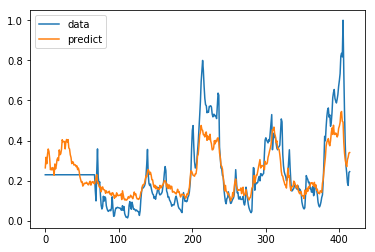

In [11]:
import tensorflow as tf

with tf.device("CPU:0"):
    vae, enc, gen = create_lstm_vae(input_dim, 
        timesteps=timesteps, 
        batch_size=batch_size, 
        intermediate_dim=32,
        latent_dim=100,
        epsilon_std=1.)

    vae.fit(x, x, epochs=20)

    preds = vae.predict(x, batch_size=batch_size)

    # pick a column to plot.
    print("[plotting...]")
    print("x: %s, preds: %s" % (x.shape, preds.shape))
    plt.plot(x[:,0,3], label='data')
    plt.plot(preds[:,0,3], label='predict')
    plt.legend()
    plt.show()
